In [1]:
import os
import cv2
import argparse
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from xml.dom import minidom
from natsort import natsorted
from dataclasses import dataclass
from Utils import rotate_image, create_dir, group_lines, preprocess_img, parse_labels
from IPython.display import Image as ShowImage

def show_image(img):
    display(Image.fromarray(img))



@dataclass
class LineSample:
    """Class for keeping track of an item in inventory."""
    image: np.array
    label: str
    x: float
    y: float
    width: float
    height: float


def generate_line_image_v1(image, contour, angle: float, kernel: tuple = (10, 16), iterations: int = 6):
    image_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.drawContours(image_mask, [contour], contourIdx=-1, color=(255, 255, 255), thickness=-1)

    dilate_k = np.ones(kernel, dtype=np.uint8)
    kernel_iterations = iterations

    image_mask = cv2.dilate(image_mask, dilate_k, iterations=kernel_iterations)
    image_masked = cv2.bitwise_and(image, image, mask=image_mask)

    if angle > 85.0 and angle != 90.0:
        angle = -(90 - angle)

    if angle == 90:
        angle = 0
        
    rotated_img = rotate_image(image_masked, angle=angle)

    cropped_img = np.delete(rotated_img, np.where(~rotated_img.any(axis=1))[0], axis=0)
    cropped_img = np.delete(cropped_img,np.where(~cropped_img.any(axis=0))[0], axis=1)

    #indices = np.where(cropped_img[:, :]==0)
    #clear = cropped_img.copy()
    #clear[indices[0], indices[1]] = [255, 255, 255]
    #clear_bw = cv2.cvtColor(clear, cv2.COLOR_BGR2GRAY)
    #_ ,thresh = cv2.threshold(clear_bw, 170, 255,cv2.THRESH_BINARY)


    return cropped_img

In [2]:
def strict_binarize(image: np.array, blur_intensity: int = 5, lower_thresh: int = 130) -> np.array:
    #clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(24, 24))
    #bw = clahe.apply(image)
    #bw = cv2.GaussianBlur(bw, (blur_intensity, blur_intensity), 0)
    #bw = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 11)
    bw = cv2.threshold(image, lower_thresh, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #thresh_c = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
    #indices = np.where(thresh_c == 0)
    #thresh_c = thresh_c.copy()
    #thresh_c[indices[0], indices[1], :] = [0, 255, 0]

    return bw

def blurr(image: np.array, blur_intensity: int = 4):
    bw = cv2.GaussianBlur(image, (blur_intensity, blur_intensity), 0)
    return bw

def adaptive_binarize(image: np.array, block_size: int = 13, c: float = 11, invert: bool = False):
    c = round(c, 2)
    
    bw = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)

    if invert:
        bw = cv2.bitwise_not(bw)

    return bw


def get_components(image: np.array):
    connectivity = 4 # or 8, check here: https://stackoverflow.com/questions/7088678/4-connected-vs-8-connected-in-connected-component-labeling-what-is-are-the-meri
    image = cv2.bitwise_not(image)
    output = cv2.connectedComponentsWithStats(image, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = output

    return numLabels, labels, stats, centroids

def get_component_info(index: int, stats, centroids):
           
    x = stats[index, cv2.CC_STAT_LEFT]
    y = stats[index, cv2.CC_STAT_TOP]
    w = stats[index, cv2.CC_STAT_WIDTH]
    h = stats[index, cv2.CC_STAT_HEIGHT]
    area = stats[index, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[index]
    return x, y, w, h, cX, cY, area

def filter_components(image: np.array, y_offset: int = 3, area_threshold: int = 6, y_border: bool = True, x_border: bool = False, filter_area: bool = True):

    mask = np.zeros(image.shape, dtype="uint8")
    numLabels, labels, stats, centroids = get_components(image)

    for compnt_idx in range(0, numLabels):
        x, y, w, h, cX, cY, area = get_component_info(compnt_idx, stats, centroids)

        # component touches the border
        x_pos = x > 0 and x+w < image.shape[1] - 1
        y_pos = y > 0 and y+h < image.shape[0] - 1
        #y_pos = y > 0

        cy_filter = cY > y_offset and cY < image.shape[0] - y_offset
        #keepArea = area > 500 and area < 1500
        area_size = area > area_threshold

        filters = []
        filters.append(cy_filter)
        
        if x_border:
            filters.append(x_pos)

        if y_border:
            filters.append(y_pos)

        if filter_area:
            filters.append(area_size)

        if all(filters):
            componentMask = (labels == compnt_idx).astype("uint8") * 255
            mask = cv2.bitwise_or(mask, componentMask)

    mask = cv2.bitwise_not(mask)
    return mask


def save_line_transcription(file_name, index, image, label, images_out, labels_out):
    line_img_path = os.path.join(images_out, f"{file_name}_{index}.jpg")
    cv2.imwrite(line_img_path, image)

    labe_file_path = os.path.join(labels_out, f"{file_name}_{index}.txt")

    with open(labe_file_path, "w", encoding="utf-8") as f:
        f.write(label)

In [779]:

input_dir = "D:/Datasets/Tibetan/Glomanthang/Annotations_v2/Glomanthang-Annotations"
volume_dir = "W2KG229028-v3"

dataset_images = natsorted(glob(f"{input_dir}/{volume_dir}/*.jpg"))
dataset_labels = natsorted(glob(f"{input_dir}/{volume_dir}/page/*.xml"))

print(f"Volume: {input_dir} => Images: {len(dataset_images)} , Labels: {len(dataset_labels)}")

dataset_out = os.path.join(input_dir, volume_dir, "Dataset_clean")
dataset_img_out = os.path.join(dataset_out, "lines")
dataset_transcriptions_out = os.path.join(dataset_out, "transcriptions")

create_dir(dataset_out)
create_dir(dataset_img_out)
create_dir(dataset_transcriptions_out)

assert(len(dataset_images) == len(dataset_labels))

Volume: D:/Datasets/Tibetan/Glomanthang/Annotations_v2/Glomanthang-Annotations => Images: 10 , Labels: 10


D:/Datasets/Tibetan/Glomanthang/Annotations_v2/Glomanthang-Annotations/W2KG229028-v1\I2KG2290310009.jpg


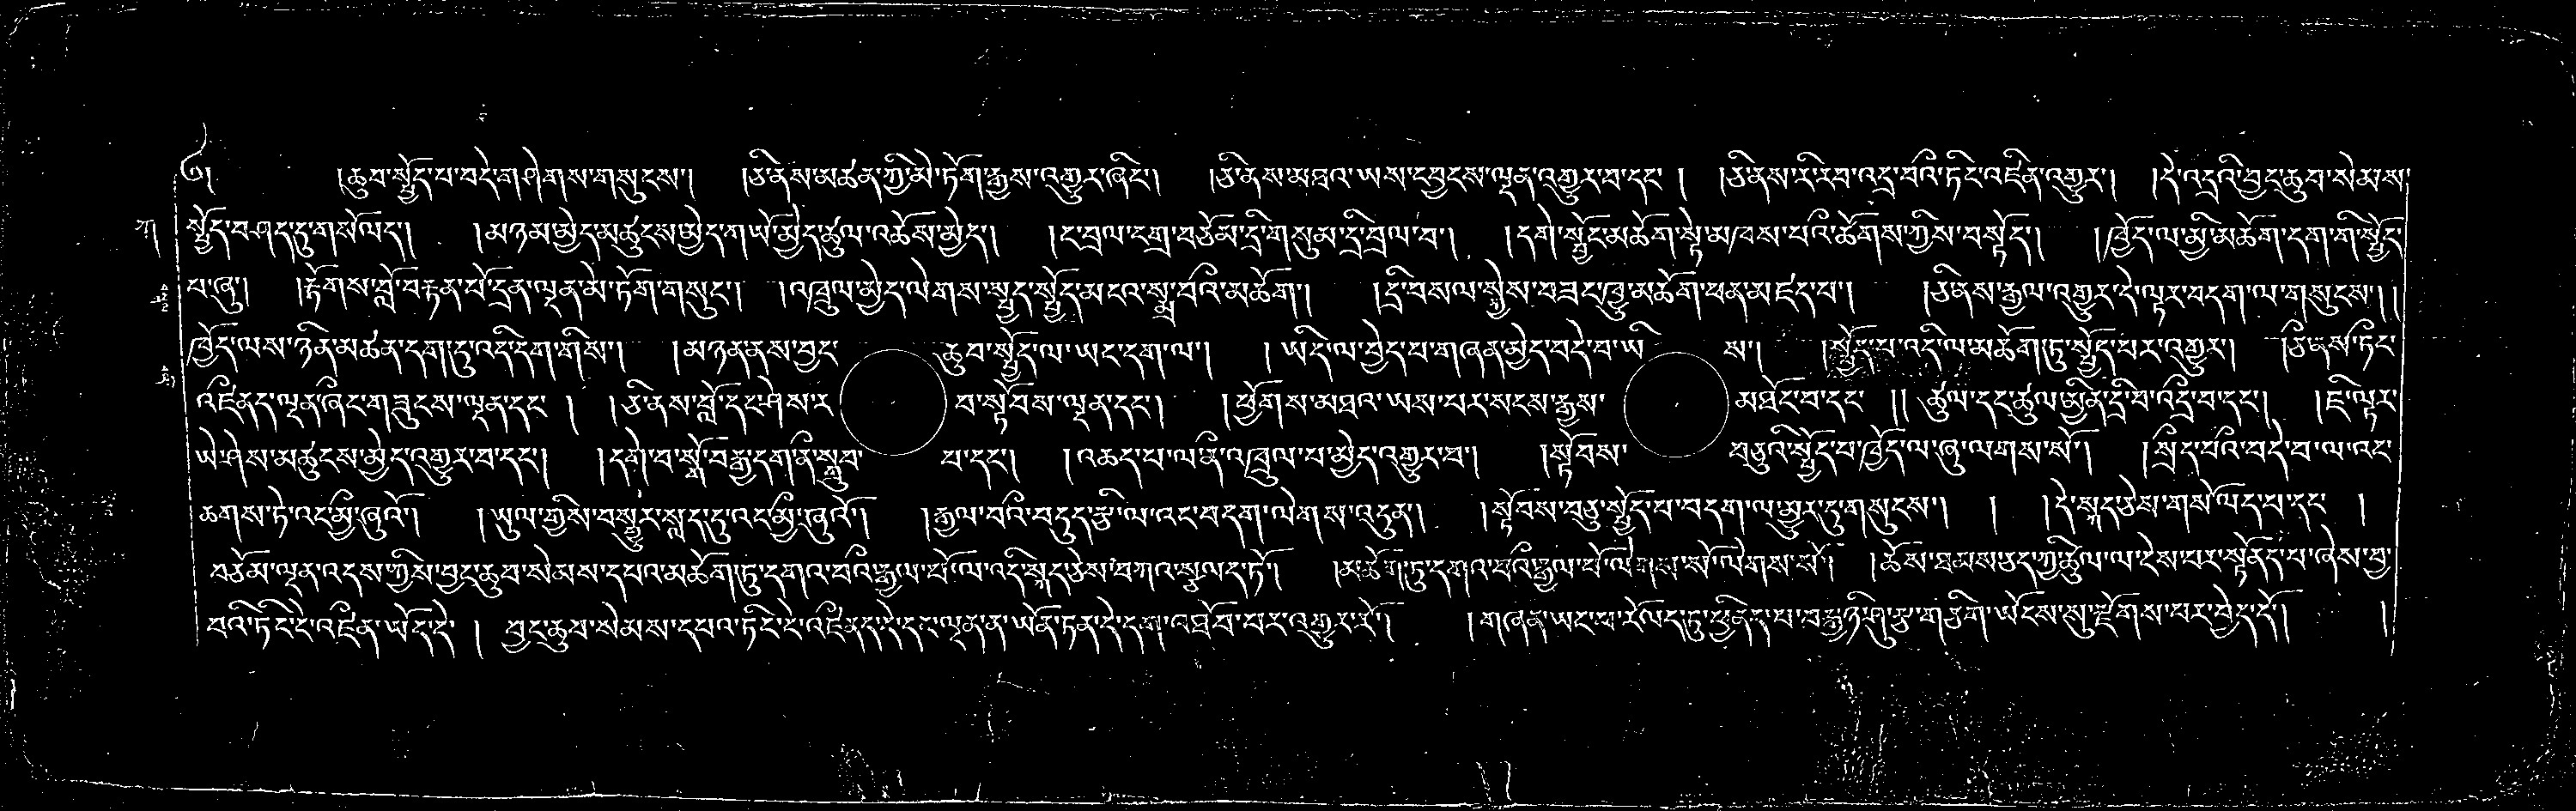

In [770]:
idx = 5
print(dataset_images[idx])


file_name = os.path.basename(dataset_images[idx]).split(".")[0]
image = cv2.imread(dataset_images[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_bw2 = blurr(image, blur_intensity=3)
image_bw2 = cv2.dilate(image_bw2, (3,3), 3)
image_bw2 = adaptive_binarize(image_bw2, invert=True, block_size=11, c=11)
show_image(image_bw2)

(101, 674)
མཚན་ནྀ་ཀླུ་སྡེ་ཞེས་བྱའོ་། །གནས་བརྟན་བཅུ་ག


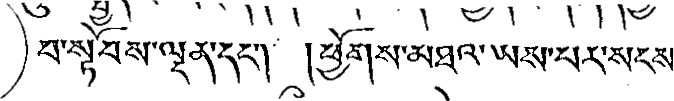

20


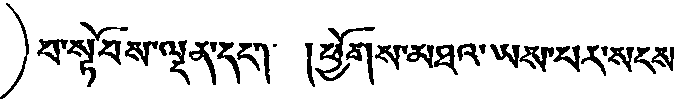

In [786]:
annotation_tree = minidom.parse(dataset_labels[idx])
textlines = annotation_tree.getElementsByTagName('TextLine')
centers, contour_dict = parse_labels(textlines, y_offset=0)


image_idx = 4
dataset: list[LineSample] = []

for line_idx, (_, (k, v)) in enumerate(zip(centers, contour_dict.items())):
        points, label, angle = v
        #print(label)
        (x, y), (width, height), angle = cv2.minAreaRect(points)
        line_image = generate_line_image_v1(image_bw2, points, angle, kernel=(6, 4), iterations=14)
        line_image = cv2.bitwise_not(line_image)
        line_sample = LineSample(line_image, label, x, y, width, height)
        dataset.append(line_sample)

print(dataset[image_idx].image.shape)
print(dataset[image_idx].label)
show_image(dataset[image_idx].image)

# filter output
y_off = int(dataset[image_idx].image.shape[0] * 0.2)
print(y_off)
filtered_image = filter_components(dataset[image_idx].image, y_offset=y_off, area_threshold=10, x_border=False)
#filtered_image = cv2.erode(filtered_image, (2,2), 1)
show_image(filtered_image)

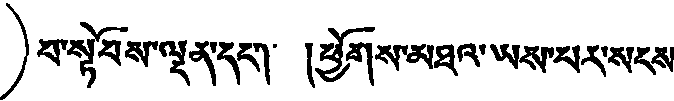

In [787]:
filtered_image = cv2.erode(filtered_image, (2,2), 1)
show_image(filtered_image)

In [3]:
def get_page_data(image: str, annotation: str) -> tuple[str, list[LineSample]]:
    
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = blurr(image, blur_intensity=3)
    image = cv2.dilate(image, (3,3), 3)
    image = adaptive_binarize(image, invert=True, block_size=11, c=11)

    annotation_tree = minidom.parse(annotation)
    textlines = annotation_tree.getElementsByTagName('TextLine')
    centers, contour_dict = parse_labels(textlines, y_offset=0)

    page_data: list[LineSample] = []

    for _, (_, (k, v)) in enumerate(zip(centers, contour_dict.items())):
        points, label, angle = v

        if len(label) > 30:
            (x, y), (width, height), angle = cv2.minAreaRect(points)
            line_image = generate_line_image_v1(image, points, angle, kernel=(6, 4), iterations=14)
            line_image = cv2.bitwise_not(line_image)
            y_off = int(line_image.shape[0] * 0.2)
            line_image = filter_components(line_image, y_offset=y_off, area_threshold=10, x_border=False)
            
            line_sample = LineSample(line_image, label, x, y, width, height)
            page_data.append(line_sample)

    return page_data

In [4]:
volumes = ["W2KG229028-v1", "W2KG229028-v2", "W2KG229028-v3", "W2KG229028-v4", "W2KG229028-v5", "W2KG229028-v6", "W2KG229028-v7", "W2KG229028-v8", "W2KG229028-v9", "W2KG229028-v10", "W2KG229028-v14", "W2KG229028-v15","W2KG229028-v17", "W2KG229028-v20", "W2KG229028-v21", "W2KG229028-v26", "W2KG229028-v28", "W2KG229028-v30"]

input_dir = "D:/Datasets/Tibetan/Glomanthang/Annotations_v2/Glomanthang-Annotations"
dataset_out = os.path.join(input_dir, "Dataset_clean")
dataset_img_out = os.path.join(dataset_out, "lines")
dataset_transcriptions_out = os.path.join(dataset_out, "transcriptions")

create_dir(dataset_out)
create_dir(dataset_img_out)
create_dir(dataset_transcriptions_out)

for volume_dir in volumes:
    

    dataset_images = natsorted(glob(f"{input_dir}/{volume_dir}/*.jpg"))
    dataset_labels = natsorted(glob(f"{input_dir}/{volume_dir}/page/*.xml"))

    print(f"Volume: {volume_dir} => Images: {len(dataset_images)} , Labels: {len(dataset_labels)}")

    for image, annotation in tqdm(zip(dataset_images, dataset_labels), total=len(dataset_images)):
        file_name = os.path.basename(image).split(".")[0]
        page_data = get_page_data(image, annotation)

        for idx, line in enumerate(page_data):
            #print(line.label)
            save_line_transcription(file_name, idx, line.image, line.label, dataset_img_out, dataset_transcriptions_out)

Volume: W2KG229028-v1 => Images: 22 , Labels: 22


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


Volume: W2KG229028-v2 => Images: 10 , Labels: 10


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Volume: W2KG229028-v3 => Images: 10 , Labels: 10


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Volume: W2KG229028-v4 => Images: 9 , Labels: 9


100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Volume: W2KG229028-v5 => Images: 10 , Labels: 10


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Volume: W2KG229028-v6 => Images: 20 , Labels: 20


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Volume: W2KG229028-v7 => Images: 11 , Labels: 11


100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


Volume: W2KG229028-v8 => Images: 11 , Labels: 11


100%|██████████| 11/11 [00:08<00:00,  1.27it/s]


Volume: W2KG229028-v9 => Images: 11 , Labels: 11


100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


Volume: W2KG229028-v10 => Images: 11 , Labels: 11


100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Volume: W2KG229028-v14 => Images: 24 , Labels: 24


100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Volume: W2KG229028-v15 => Images: 48 , Labels: 48


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Volume: W2KG229028-v17 => Images: 20 , Labels: 20


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Volume: W2KG229028-v20 => Images: 10 , Labels: 10


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Volume: W2KG229028-v21 => Images: 19 , Labels: 19


100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


Volume: W2KG229028-v26 => Images: 4 , Labels: 4


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Volume: W2KG229028-v28 => Images: 40 , Labels: 40


100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Volume: W2KG229028-v30 => Images: 112 , Labels: 112


100%|██████████| 112/112 [02:24<00:00,  1.29s/it]
